In [ ]:
%load_ext autoreload
%autoreload 2

import sys
import os

# Get current working directory (where notebook is running)
current_dir = os.getcwd()
# Go up one level
utils_path = os.path.abspath(os.path.join(current_dir, '..'))
# Add to sys.path
sys.path.append(utils_path)

from utils.trend_regime_utils import (
    load_trend_data, process_trend_data, create_advanced_feat, mayority_vote_cluster_smooth
)

import pandas as pd
import numpy as np
from datetime import datetime
from zoneinfo import ZoneInfo
import joblib
from scipy.stats.mstats import winsorize
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import matplotlib.dates as mdates
from matplotlib.collections import LineCollection
from matplotlib.patches import Patch

# For API Keys
from dotenv import load_dotenv
# Alpaca API keys
API_KEY = None
SECRET_KEY = None

load_dotenv(override=True)

if API_KEY is None:
    API_KEY = os.environ.get('ALP_API_KEY')

if SECRET_KEY is None:
    SECRET_KEY = os.environ.get('ALP_SEC_KEY')

In [2]:
EARLIEST_DATE = datetime(2016, 1, 16, tzinfo=ZoneInfo('America/New_York'))
LAST_DATE = datetime(2025, 7, 20, tzinfo=ZoneInfo('America/New_York'))

df_trend_raw = load_trend_data(API_KEY, SECRET_KEY, EARLIEST_DATE, LAST_DATE)

df_trend_processed = process_trend_data(df_trend_raw)

df_trend_feat = create_advanced_feat(df_trend_processed)

c:\Users\sergi\Documents\TFG\utils\trend_regime_utils.py:96: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_feat = df_subset.groupby('symbol').apply(compute_trend_features)
c:\Users\sergi\Documents\TFG\utils\trend_regime_utils.py:96: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_feat = df_subset.groupby('symbol').apply(compute_trend_features)
c:\Users\sergi\Documents\TFG\utils\trend_regime_utils.py:96: FutureWar

In [3]:
# Get the project root (one level up from current working directory)
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
MODEL_DIR = os.path.join(PROJECT_ROOT, 'models')

os.makedirs(MODEL_DIR, exist_ok=True)

## If want to predict
# Load models
scaler = joblib.load(os.path.join(MODEL_DIR, "trend_scaler.pkl"))
umap_model = joblib.load(os.path.join(MODEL_DIR, "trend_umap_model.pkl"))
gmm_model = joblib.load(os.path.join(MODEL_DIR, "trend_gmm_model.pkl"))

# scale data
trend_scaled = scaler.transform(df_trend_feat)

# Apply UMAP transformation
trend_umap = umap_model.transform(trend_scaled)

# Predict clusters
trend_gmm_labels = gmm_model.predict(trend_umap)

# from sklearn.metrics import silhouette_score
# print(silhouette_score(trend_umap, trend_gmm_labels))

df_with_clusters = pd.DataFrame(trend_gmm_labels, columns=["cluster"], index=df_trend_feat.index)

df_cluster_smooth = mayority_vote_cluster_smooth(df_with_clusters)

In [4]:
# Example list – customize based on your actual dataset
us_global_equities = ['SPY', 'QQQ', 'DIA', 'IWM', 'EFA', 'EEM', 'VEA', 'VWO']
other_tickers = ['TLT', 'GLD']
bull_tickers = us_global_equities+other_tickers
df_bull_raw = load_trend_data(API_KEY, SECRET_KEY, EARLIEST_DATE, LAST_DATE, all_tickers=bull_tickers)

print(df_bull_raw.pivot(columns='symbol').isna().sum())

      symbol
open  DIA       0
      EEM       0
      EFA       0
      GLD       0
      IWM       0
               ..
vwap  QQQ       0
      SPY       0
      TLT       0
      VEA       0
      VWO       0
Length: 70, dtype: int64


In [5]:
# --- Configuration ---
ROLLING_WINDOW = 20  # You can adjust this

df_eq = df_bull_raw[df_bull_raw['symbol'].isin(us_global_equities)].sort_index().copy()
df_eq_mean = df_eq.groupby(df_eq.index).mean(numeric_only=True)

# --- Trend Consistency Score ---
df_eq_mean['trend_consistency'] = ((df_eq_mean['close'] - df_eq_mean['low']) / 
                                (df_eq_mean['high'] - df_eq_mean['low'] + 1e-6)).rolling(ROLLING_WINDOW).mean()

# --- Volatility Asymmetry Index ---
returns = df_eq_mean['close'].pct_change()

def upside_vol_func(returns_window):
    pos_returns = returns_window[returns_window > 0]
    if len(pos_returns) >= 2:  # needs at least 2 points for std
        return pos_returns.std()
    else:
        return np.nan

upside_vol = returns.rolling(ROLLING_WINDOW).apply(upside_vol_func, raw=False)
total_vol = returns.rolling(ROLLING_WINDOW).std()
df_eq_mean['vol_asymmetry'] = upside_vol / (total_vol + 1e-6)

# --- Feature Higher High Consistency ---
higher_high = (df_eq_mean['high'] > df_eq_mean['high'].shift(1)).astype(int)
df_eq_mean['higher_high_consistency'] = higher_high.rolling(ROLLING_WINDOW).mean()

In [6]:
# --- Helper function to extract close price of a symbol ---
def get_close(symbol):
    return df_bull_raw[df_bull_raw['symbol'] == symbol].sort_index()['close']

# Get closes for external tickers
tlt = get_close('TLT')
gld = get_close('GLD')

external_df = pd.DataFrame(index=df_eq_mean.index)

# --- Correlations ---
external_df['long_bond_correlation'] = df_eq_mean['close'].pct_change().rolling(ROLLING_WINDOW).corr(tlt.pct_change())
external_df['gold_correlation'] = df_eq_mean['close'].pct_change().rolling(ROLLING_WINDOW).corr(gld.pct_change())

In [7]:
# Combine SPY-only features and external features
bull_features_df = pd.concat([df_eq_mean[['trend_consistency', 'vol_asymmetry', 'higher_high_consistency']],
                         external_df], axis=1)

# Optional: Drop rows with missing values
print(bull_features_df.isna().sum())
bull_features_df.dropna(inplace=True)


trend_consistency          19
vol_asymmetry              20
higher_high_consistency    19
long_bond_correlation      20
gold_correlation           20
dtype: int64


In [8]:
# keep only bull days 
bull_days = df_cluster_smooth[df_cluster_smooth==1]

# Keep only rows in bull_features_df where the index exists in bull_days
only_bull_features_df = bull_features_df[bull_features_df.index.isin(bull_days.index)]

In [ ]:
N_COMP=3
N_NEIG=55
MIN_D = 0.01
METRIC = "correlation"

RANDOM_STATE = 0

K=2

# Store results
results = []

scaled = StandardScaler().fit_transform(only_bull_features_df)

# Apply UMAP
X_umap = umap.UMAP(
    n_neighbors=N_NEIG,
    min_dist=MIN_D,
    n_components=N_COMP,
    metric=METRIC,
    random_state=RANDOM_STATE
).fit_transform(scaled)

model = SpectralClustering(
    n_clusters=K,
    affinity='rbf',
    assign_labels='kmeans',
    random_state=RANDOM_STATE
)
labels = model.fit_predict(X_umap)

sil = silhouette_score(X_umap, labels)
ch = calinski_harabasz_score(X_umap, labels)
db = davies_bouldin_score(X_umap, labels)
print("silhouette_score", sil)

c:\Users\sergi\Documents\TFG\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


silhouette_score 0.48621028661727905


In [10]:
# ## Save scaler, umap, and model
# import joblib

# PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
# MODEL_DIR = os.path.join(PROJECT_ROOT, 'models')

# os.makedirs(MODEL_DIR, exist_ok=True)

# # Save the scaler
# scaler = StandardScaler().fit(only_bull_features_df.values)
# joblib.dump(scaler, os.path.join(MODEL_DIR, "bull_trend_scaler.pkl"))

# # Save the fitted UMAP model
# umap_model = umap.UMAP(
#     n_neighbors=N_NEIG,
#     min_dist=MIN_D,
#     n_components=N_COMP,
#     metric=METRIC,
#     random_state=RANDOM_STATE
# ).fit(scaled)
# joblib.dump(umap_model, os.path.join(MODEL_DIR, "bull_trend_umap_model.pkl"))

# # Save the trained model
# joblib.dump(model, os.path.join(MODEL_DIR, "bull_trend_spectral_model.pkl"))

In [11]:
# since 0 cluster was previously another cluster replace 0s with 5th clusters, 4s
labels = np.where(labels == 0, 4, labels)

C:\Users\sergi\AppData\Local\Temp\ipykernel_1424\1155570498.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab20', n_clusters)  # get n discrete colors from RdBu


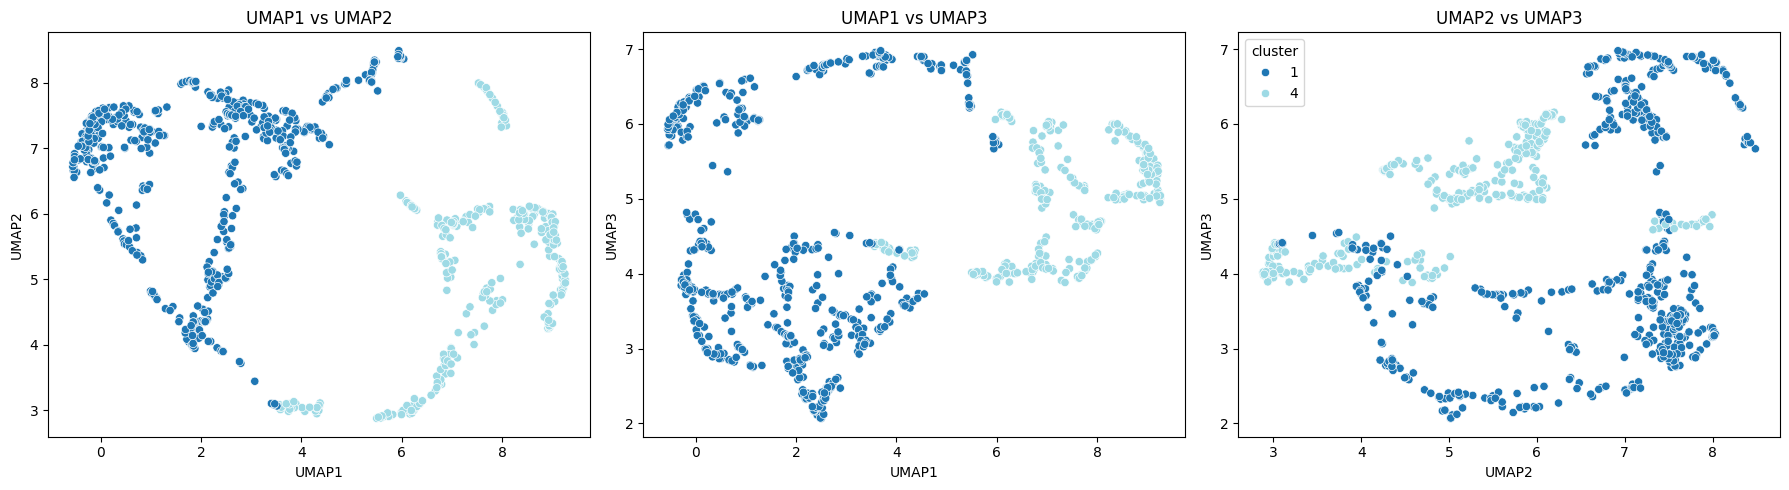

In [12]:
from matplotlib.cm import get_cmap
from matplotlib.colors import to_hex

# Create DataFrame
umap_df = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2', 'UMAP3'])
umap_df['cluster'] = labels

# Get unique number of clusters (excluding noise if applicable)
unique_clusters = sorted(set(umap_df['cluster']))
n_clusters = len(unique_clusters)

# Get RdBu colormap and convert to discrete hex palette
cmap = get_cmap('tab20', n_clusters)  # get n discrete colors from RdBu
palette = [to_hex(cmap(i)) for i in range(n_clusters)]

# Map cluster labels to palette indices
label_to_color = {label: palette[i] for i, label in enumerate(unique_clusters)}
umap_df['color'] = umap_df['cluster'].map(label_to_color)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='cluster', palette=label_to_color, ax=axes[0])
axes[0].set_title('UMAP1 vs UMAP2')

sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP3', hue='cluster', palette=label_to_color, ax=axes[1])
axes[1].set_title('UMAP1 vs UMAP3')

sns.scatterplot(data=umap_df, x='UMAP2', y='UMAP3', hue='cluster', palette=label_to_color, ax=axes[2])
axes[2].set_title('UMAP2 vs UMAP3')

for ax in axes[:-1]:
    ax.legend().remove()

plt.tight_layout()
plt.show()

In [13]:
pd.Series(labels).value_counts(normalize=True)

1    0.640878
4    0.359122
Name: proportion, dtype: float64

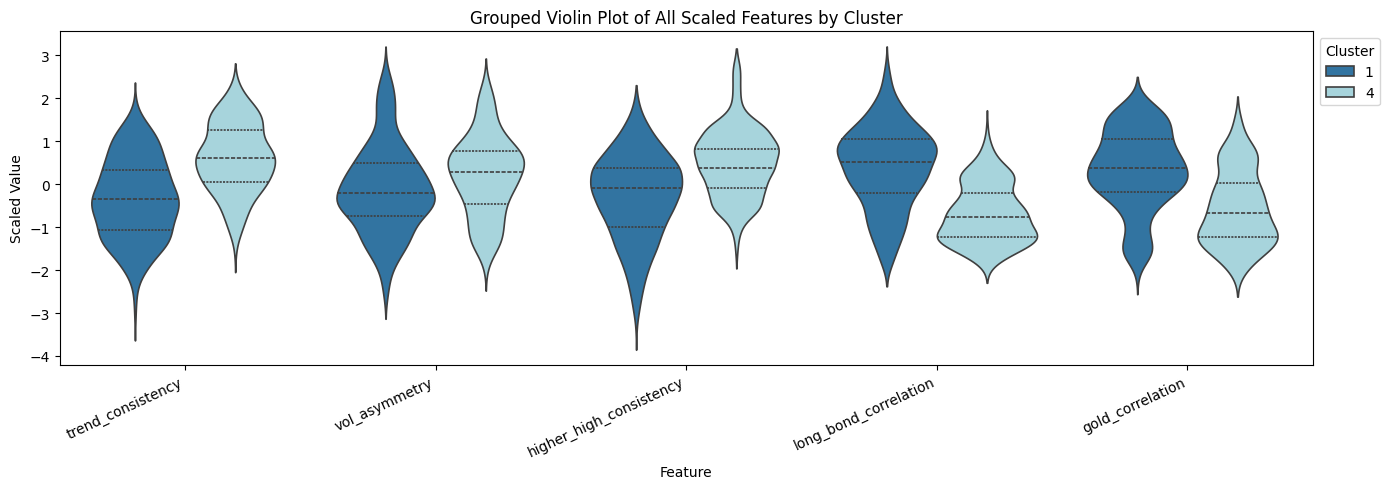

In [ ]:
df_interpret = pd.DataFrame(scaled, columns=only_bull_features_df.columns, index=only_bull_features_df.index)
# Assign cluster labels
df_interpret['Cluster'] = labels

# Melt the dataframe to long format for seaborn
df_melted = df_interpret.reset_index().melt(id_vars=['Cluster'], 
                                              value_vars=df_interpret.columns,
                                              var_name='Feature', 
                                              value_name='Scaled Value')
# Create grouped violin plot
plt.figure(figsize=(14, 5))
sns.violinplot(
    data=df_melted,
    x='Feature',
    y='Scaled Value',
    hue='Cluster',
    palette=palette,
    split=False,        # Merge both clusters' violins in one shape if applicable
    inner='quartile',  # Show quartiles instead of full box
    linewidth=1.2
)

plt.title('Grouped Violin Plot of All Scaled Features by Cluster')
plt.ylabel('Scaled Value')
plt.legend(title='Cluster', bbox_to_anchor=(1, 1), loc='upper left')
plt.xticks(rotation=25, ha='right') # Rotate by 45 degrees, align right
plt.tight_layout()
plt.show()

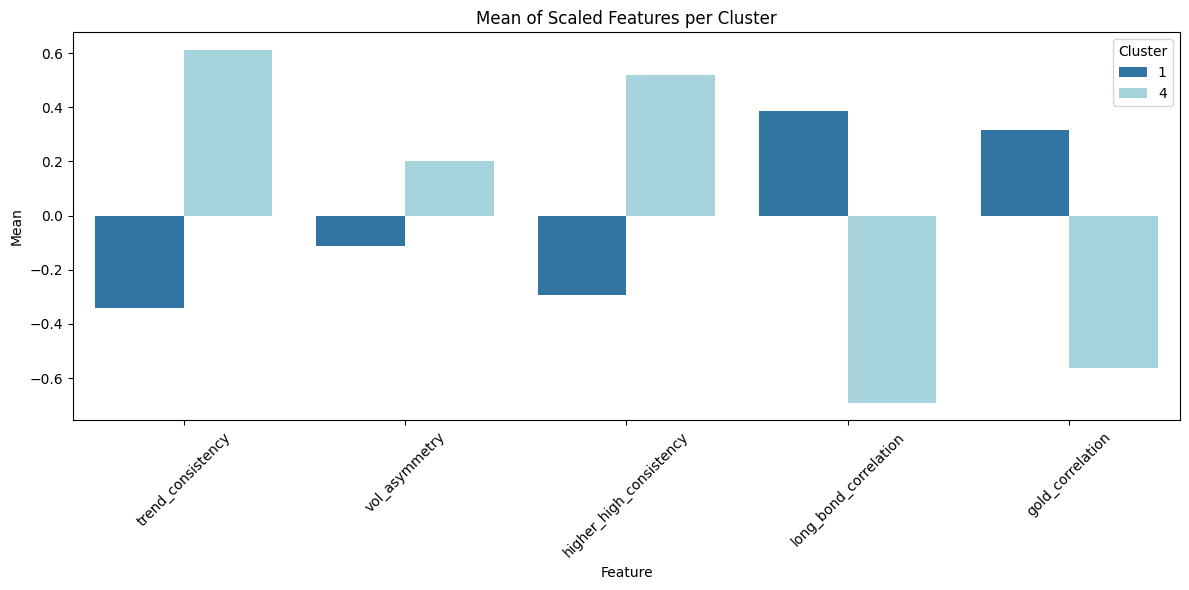

In [ ]:
# Create a DataFrame with scaled features and labels
df_scaled = pd.DataFrame(scaled, columns=only_bull_features_df.columns)
df_scaled['Cluster'] = labels

# Compute mean of each feature per cluster
cluster_means = df_scaled.groupby('Cluster').mean()

# Reshape for plotting
cluster_means_melted = cluster_means.reset_index().melt(id_vars='Cluster', var_name='Feature', value_name='Mean')

# Get unique clusters and generate RdBu-based color palette
unique_clusters = sorted(cluster_means_melted['Cluster'].unique())
n_clusters = len(unique_clusters)

palette = [to_hex(cmap(i)) for i in range(n_clusters)]
cluster_color_map = {label: palette[i] for i, label in enumerate(unique_clusters)}

# Plot grouped barplot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=cluster_means_melted,
    x='Feature',
    y='Mean',
    hue='Cluster',
    palette=cluster_color_map  # Use custom RdBu palette
)
plt.title('Mean of Scaled Features per Cluster')
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

# cluster 1 (dark blue): calm/consolidating/defensive bull
# cluster 4 (light blue): strong/aggresive/impulsive/risk-on bull


In [16]:
df_2_plot = load_trend_data(API_KEY, SECRET_KEY, EARLIEST_DATE, LAST_DATE, all_tickers=['SPY'])

df_2_plot = df_2_plot.sort_values(by=['symbol', 'timestamp']) # Ensure sorted for correct rolling calcs
# remove first days that do not have cluster
df_2_plot =  df_2_plot[len(df_2_plot)-len(df_trend_feat):]

# Merge cluster labels into df_2_plot
df_with_bull_clusters = df_2_plot.copy()
# Prepare the dataframe with timestamp index and cluster labels
df_time_clustered = only_bull_features_df.copy()
df_time_clustered['Cluster'] = labels
df_time_clustered = df_time_clustered.sort_index()  # Ensure it's sorted by time

# fill other non-bull days with -1
df_with_bull_clusters['Cluster'] = df_time_clustered['Cluster'].reindex(df_2_plot.index).fillna(-1).astype(int)

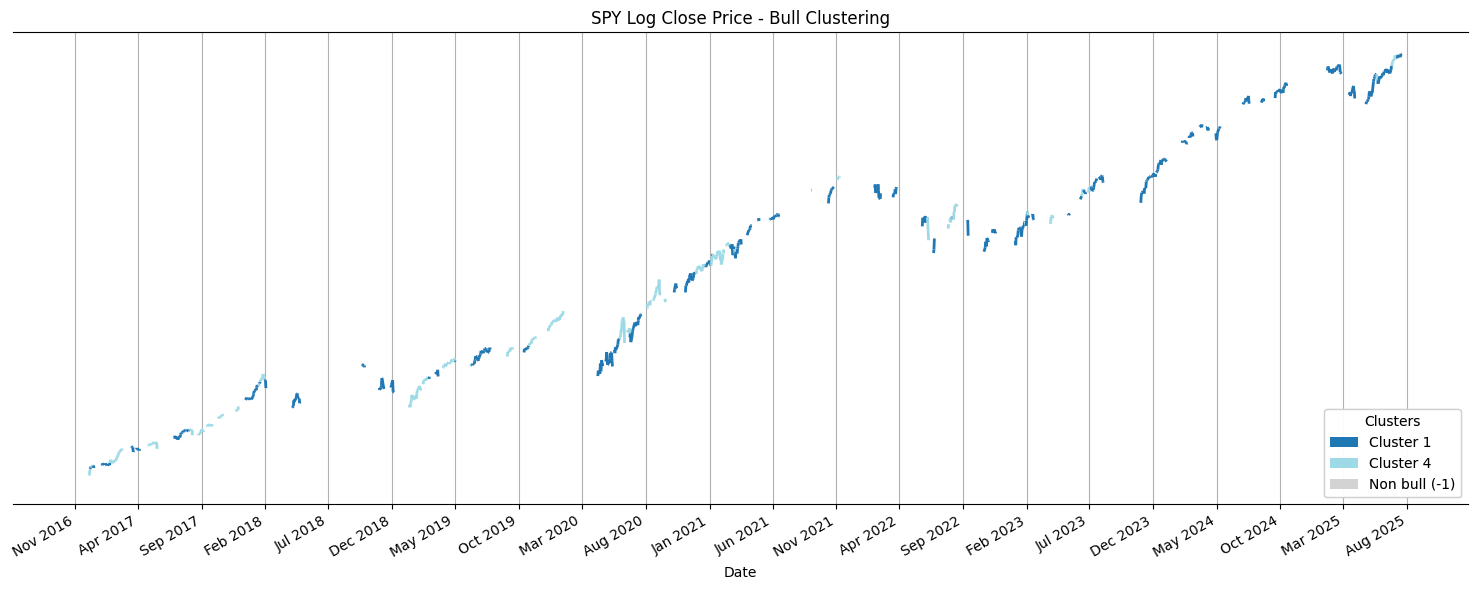

In [ ]:
# Prepare data for original line
dates = df_with_bull_clusters.index
date_nums = mdates.date2num(dates)

# Scaled log close price
close_prices_scaled = np.log(df_with_bull_clusters['close'].values)
clusters = df_with_bull_clusters['Cluster'].values

# Create line segments for original line
points = np.array([date_nums, close_prices_scaled]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Filter valid clusters (exclude -1 0 non-bull clusters)
valid_clusters = clusters[clusters != -1]
norm = plt.Normalize(valid_clusters.min(), valid_clusters.max())

# Prepare array for colors: NaN for noise so LineCollection ignores color mapping
color_array = np.where(clusters[:-1] == -1, np.nan, clusters[:-1])

# LineCollection
lc1 = LineCollection(segments, cmap=cmap, norm=norm)
lc1.set_array(color_array)
lc1.set_linewidth(2)

# Plot
fig, ax = plt.subplots(figsize=(15, 6))
ax.add_collection(lc1)
ax.autoscale()
ax.set_title("SPY Log Close Price - Bull Clustering")
ax.set_xlabel("Date")

# Remove y-axis
ax.set_ylabel("")
ax.yaxis.set_ticks([])
ax.yaxis.set_ticklabels([])
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True)

# Format x-axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
fig.autofmt_xdate()

# Legend (only valid clusters, gray for noise)
unique_clusters1 = [c for c in np.unique(clusters) if c != -1]
legend_elements1 = [Patch(facecolor=cmap(norm(c)), label=f'Cluster {c}') for c in unique_clusters1]
legend_elements1.append(Patch(facecolor='lightgray', label='Non bull (-1)'))  # add noise separately
legend1 = ax.legend(handles=legend_elements1, loc="lower right", title="Clusters")
ax.add_artist(legend1)

plt.tight_layout()
plt.show()

In [18]:
bull_trend_spectral_labels = labels.copy() # with 0s already replaced with 4s

df_with_bull_clusters = pd.DataFrame(bull_trend_spectral_labels, columns=["cluster_bull"], index=only_bull_features_df.index)

# compute final clusters
df_final_clusters = df_with_clusters.join(df_with_bull_clusters, how="outer")
# use new bull division, and the previous clusers non-bull
df_final_clusters['final_cluster'] = df_final_clusters['cluster_bull'].fillna(df_final_clusters['cluster_smooth']).astype(int)
# keep only them
df_final_clusters = df_final_clusters[['final_cluster']]
df_final_clusters.value_counts(normalize=True, dropna=False)

final_cluster
1                0.254470
0                0.240715
2                0.186612
3                0.175608
4                0.142595
Name: proportion, dtype: float64

C:\Users\sergi\AppData\Local\Temp\ipykernel_1424\1363165351.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  accent = cm.get_cmap('Accent', 4)
C:\Users\sergi\AppData\Local\Temp\ipykernel_1424\1363165351.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  tab20 = cm.get_cmap('tab20', 2)


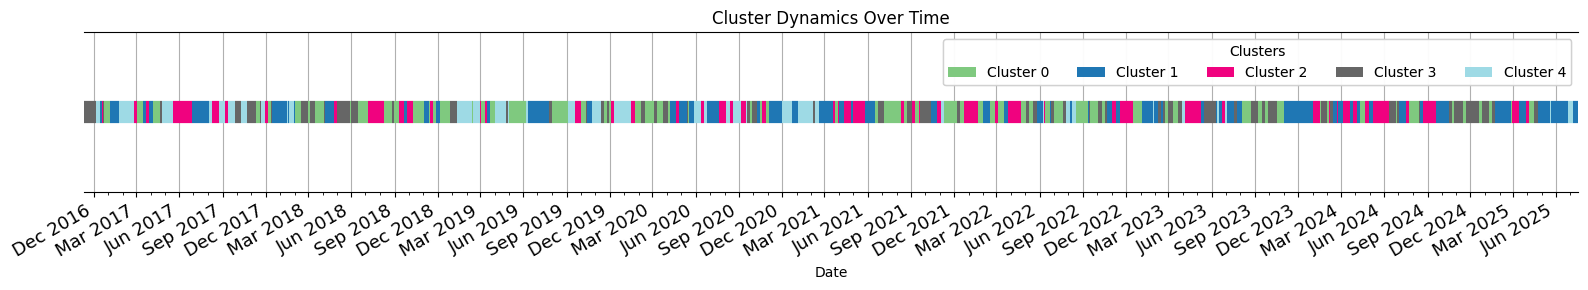

In [ ]:
# Merge cluster labels into df_2_plot
df_plot_final_clusters = df_2_plot.copy()
# Prepare the dataframe with timestamp index and cluster labels
df_time_clustered = df_final_clusters[['final_cluster']]

df_time_clustered = df_time_clustered.sort_index()  # Ensure it's sorted by time

# fill other non-bull days with -1
df_plot_final_clusters['final_cluster'] = df_time_clustered['final_cluster'].reindex(df_2_plot.index).astype(int)

# Prepare data for original line
dates = df_plot_final_clusters.index
date_nums = mdates.date2num(dates)

# Scaled log close price
close_prices_scaled = [1] * df_plot_final_clusters.shape[0]
clusters = df_plot_final_clusters['final_cluster'].values

# Create line segments for original line
points = np.array([date_nums, close_prices_scaled]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Sample accent with 4 colors (clusters 0 to 3)
accent = cm.get_cmap('Accent', 4)
accent_colors = accent(np.arange(4))  # shape (4,4)
# Sample tab20 with 2 colors for clusters 1 and 4
tab20 = cm.get_cmap('tab20', 2)
tab20_colors = tab20(np.arange(2))  # shape (2,4)
# Replace accent color for cluster 1 with tab20's first color
accent_colors[1] = tab20_colors[0]
# Now build final color array for clusters 0 to 4
# For clusters 0,2,3 use accent_colors, for cluster 1 accent_colors[1] (already replaced), for cluster 4 use tab20 second color
final_colors = np.vstack([
    accent_colors[0],  # cluster 0
    accent_colors[1],  # cluster 1 (tab20 color)
    accent_colors[2],  # cluster 2
    accent_colors[3],  # cluster 3
    tab20_colors[1] # cluster 4
])
# Create custom colormap for clusters 0 to 4
custom_cmap = ListedColormap(final_colors)
# Normalize cluster values 0-4
norm = plt.Normalize(vmin=0, vmax=4)

# LineCollection
lc1 = LineCollection(segments, cmap=custom_cmap, norm=norm)
lc1.set_array(clusters)
lc1.set_linewidth(16)

# Plot
fig, ax = plt.subplots(figsize=(16, 3))
ax.add_collection(lc1)
ax.autoscale()
ax.set_title("Cluster Dynamics Over Time")
ax.set_xlabel("Date")
ax.tick_params(axis='x', labelsize=13)

# Remove y-axis
ax.set_ylabel("")
ax.yaxis.set_ticks([])
ax.yaxis.set_ticklabels([])
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True)

# Format x-axis

# Set the x-axis limits to the exact range of your data
ax.set_xlim(date_nums[0], date_nums[-1])

# Format x-axis with an interval of 2 months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Format x-axis with a minor tick locator
ax.xaxis.set_minor_locator(mdates.MonthLocator())
fig.autofmt_xdate()

# Legend (only valid clusters, gray for noise)
unique_clusters1 = [c for c in np.unique(clusters)]
legend_elements1 = [Patch(facecolor=custom_cmap(norm(c)), label=f'Cluster {c}') for c in unique_clusters1]
legend1 = ax.legend(handles=legend_elements1, loc="upper right", ncol=len(unique_clusters1), title="Clusters")
ax.add_artist(legend1)

plt.tight_layout()
plt.show()

C:\Users\sergi\AppData\Local\Temp\ipykernel_1424\496323609.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  accent = cm.get_cmap('Accent', 4)
C:\Users\sergi\AppData\Local\Temp\ipykernel_1424\496323609.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  tab20 = cm.get_cmap('tab20', 2)


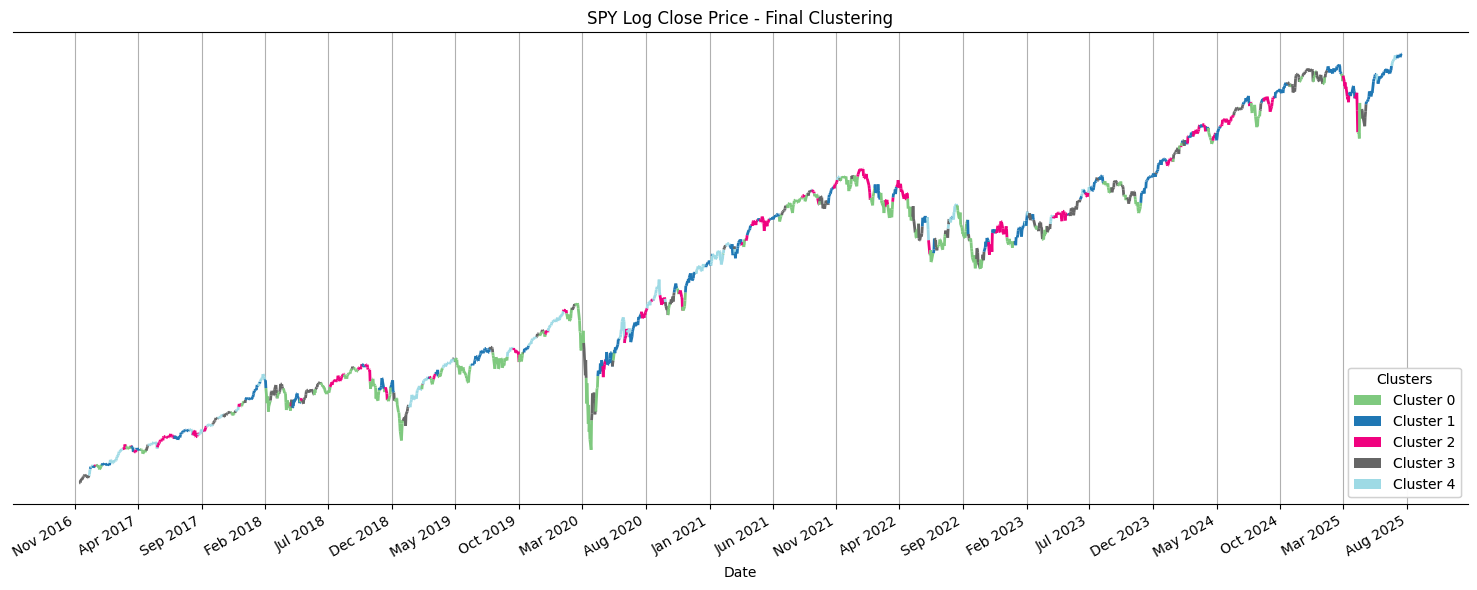

In [ ]:
# Merge cluster labels into df_2_plot
df_plot_final_clusters = df_2_plot.copy()
# Prepare the dataframe with timestamp index and cluster labels
df_time_clustered = df_final_clusters[['final_cluster']]

df_time_clustered = df_time_clustered.sort_index()  # Ensure it's sorted by time

# fill other non-bull days with -1
df_plot_final_clusters['final_cluster'] = df_time_clustered['final_cluster'].reindex(df_2_plot.index).astype(int)

# Prepare data for original line
dates = df_plot_final_clusters.index
date_nums = mdates.date2num(dates)

# Scaled log close price
close_prices_scaled = np.log(df_plot_final_clusters['close'].values)
clusters = df_plot_final_clusters['final_cluster'].values

# Create line segments for original line
points = np.array([date_nums, close_prices_scaled]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Sample accent with 4 colors (clusters 0 to 3)
accent = cm.get_cmap('Accent', 4)
accent_colors = accent(np.arange(4))  # shape (4,4)
# Sample tab20 with 2 colors for clusters 1 and 4
tab20 = cm.get_cmap('tab20', 2)
tab20_colors = tab20(np.arange(2))  # shape (2,4)
# Replace accent color for cluster 1 with tab20's first color
accent_colors[1] = tab20_colors[0]
# Now build final color array for clusters 0 to 4
# For clusters 0,2,3 use accent_colors, for cluster 1 accent_colors[1] (already replaced), for cluster 4 use tab20 second color
final_colors = np.vstack([
    accent_colors[0],  # cluster 0
    accent_colors[1],  # cluster 1 (tab20 color)
    accent_colors[2],  # cluster 2
    accent_colors[3],  # cluster 3
    tab20_colors[1] # cluster 4
])
# Create custom colormap for clusters 0 to 4
custom_cmap = ListedColormap(final_colors)
# Normalize cluster values 0-4
norm = plt.Normalize(vmin=0, vmax=4)

# LineCollection
lc1 = LineCollection(segments, cmap=custom_cmap, norm=norm)
lc1.set_array(clusters)
lc1.set_linewidth(2)

# Plot
fig, ax = plt.subplots(figsize=(15, 6))
ax.add_collection(lc1)
ax.autoscale()
ax.set_title("SPY Log Close Price - Final Clustering")
ax.set_xlabel("Date")

# Remove y-axis
ax.set_ylabel("")
ax.yaxis.set_ticks([])
ax.yaxis.set_ticklabels([])
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True)

# Format x-axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
fig.autofmt_xdate()

# Legend (only valid clusters, gray for noise)
unique_clusters1 = [c for c in np.unique(clusters)]
legend_elements1 = [Patch(facecolor=custom_cmap(norm(c)), label=f'Cluster {c}') for c in unique_clusters1]
legend1 = ax.legend(handles=legend_elements1, loc="lower right", title="Clusters")
ax.add_artist(legend1)

plt.tight_layout()
plt.show()